# MATH516 Coursework Script

## Student ID: 10648902

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from imblearn.metrics import specificity_score
from imblearn.metrics import sensitivity_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

df_raw = pd.read_csv(r"./data/Data_training_and_val_set_CNvsAD.csv")

df_raw = df_raw.drop(columns = ["RID"]) # Immediately remove patient identifiers from our data

print("Packages and data have successfully been loaded in")

Packages and data have successfully been loaded in


# Exporatory Data Analysis

### Initial inspection of data

In [2]:
print(df_raw.isna().sum()) # Notice there's no missing data

print("")
print("No data is missing")
print("")

print(df_raw["DXCURREN"].value_counts()) # Notice there's an equal number of patients with and withour dementia

print("")
print("An equal number of patients have either been diagnosed with dementia (1), or not (0)")
print("")

BRAIN         0
EICV          0
VENTRICLES    0
LHIPPOC       0
RHIPPOC       0
LINFLATVEN    0
RINFLATVEN    0
LMIDTEMP      0
RMIDTEMP      0
LINFTEMP      0
RINFTEMP      0
LFUSIFORM     0
RFUSIFORM     0
LENTORHIN     0
RENTORHIN     0
DXCURREN      0
dtype: int64

No data is missing

0    110
1    110
Name: DXCURREN, dtype: int64

An equal number of patients have either been diagnosed with dementia (1), or not (0)



### Summary statistics

In [3]:
#df_raw # Our original dataframe
df_raw_ad = df_raw[df_raw["DXCURREN"] == 1] # Dementia patients
df_raw_cn = df_raw[df_raw["DXCURREN"] == 0] # Cognitively normal patients

summary_stats_whole = (((df_raw.describe())[1:].T)[:-1]).drop(  # Removes "count" column and "DXCURREN" row
                                                              columns = ["25%", "75%"]).round(
                                                            decimals = 2) # Rounds to 2 decimal places

# The 25% and 75% quantiles were dropped from the table because they don't provide much information,
# and our report doesn't can't dispay the much bigger table "summary_stats_adcn" properly with too many columns

summary_stats_whole # Summary statistics for data

summary_stats_ad = df_raw_ad.describe() # Summary statistics for AD patients
summary_stats_cn = df_raw_cn.describe() # Summary statistics for CN patients

summary_stats_adcn = (pd.concat([summary_stats_ad, summary_stats_cn])).drop(
    columns = "DXCURREN").iloc[[1, 9, 2, 10, 3, 11, 5, 13, 7, 15]] # Remove counts for AD and CN
# Also, rearranged rows to make a table for ease of comparison between AD and CN

# Note that 25% and 75% quantiles were purposefully excluded so the table in the report is legible, as there's less columns

summary_stats_adcn = ((summary_stats_adcn.reset_index().rename(index = #Summary statistics for both AD and CN patients, in one table
                                  {0: "Mean (AD)", 1: "Mean (CN)",
                                   2: "Std (AD)", 3: "Std (CN)",
                                   4: "Min (AD)", 5: "Min (CN)", 
                                   6: "Median (AD)", 7: "Median (CN)",
                                   8: "Max (AD)", 9: "Max (CN)"})).drop(columns = "index").T)

#summary_stats_whole
#summary_stats_whole.to_csv(r"./output/summ_whole.txt", sep = ",", float_format = "{:.2f}".format) # Saves table to an external .txt file

In [4]:
#summary_stats_adcn
#summary_stats_adcn.to_csv(r"./output/summ_adcn.txt", sep = ","float_format = "{:.2f}".format)

### Boxplots

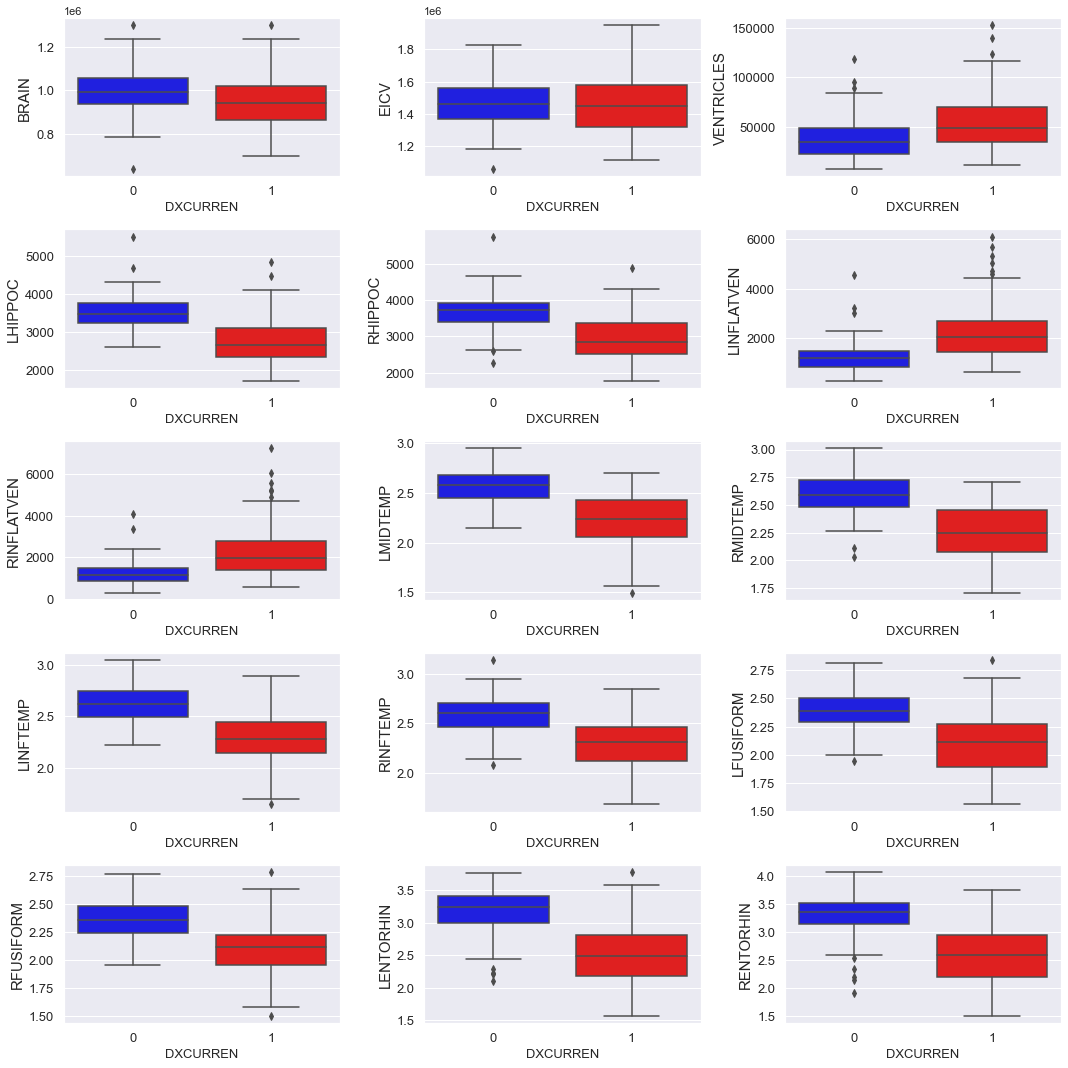

In [5]:
sns.set()

features_raw=df_raw.drop(columns=['DXCURREN']).columns # List of column names, excluing the classification label

fig, axes = plt.subplots(5, 3, figsize = (15,15))

fig_2_df = df_raw

custom_palette = {1 : "red", 0 : "blue"} # Custom colours for

count = 0 # The feature number selected

for i in range(0 ,5): # Iterates across rows
    j = 0
    while j<3: # Iterates across columns
        plot = sns.boxplot(x = fig_2_df["DXCURREN"], y = df_raw[features_raw[count]], ax = axes[i, j], palette = custom_palette)
        plot.set_ylabel(features_raw[count], fontsize = 15)
        plot.set_xlabel("DXCURREN", fontsize = 13)
        plot.tick_params(labelsize = 13) # Size of the ticks
        j += 1
        count += 1

plt.tight_layout()
#plt.savefig(r"./output/Figure_2.png")

Features where there's a lot of difference include: VENTRICLES, LHIPPOC, RHIPPOC, LINFLATVEN, RINFLATVEN, LMIDTEMP, RMIDTEMP, LINFTEMP, RINFTEMP, LFUSIFORM, RFUSIFORM, LENTORHIN, RENTORHIN

Features where there's a lot of similarities include: BRAIN, EICV

Thus, after box plot inspection we could decide to remove BRAIN and EICV features. Although BRAIN is slightly more different for both groups compared to EICV, which is very similar

### Correlation coefficients

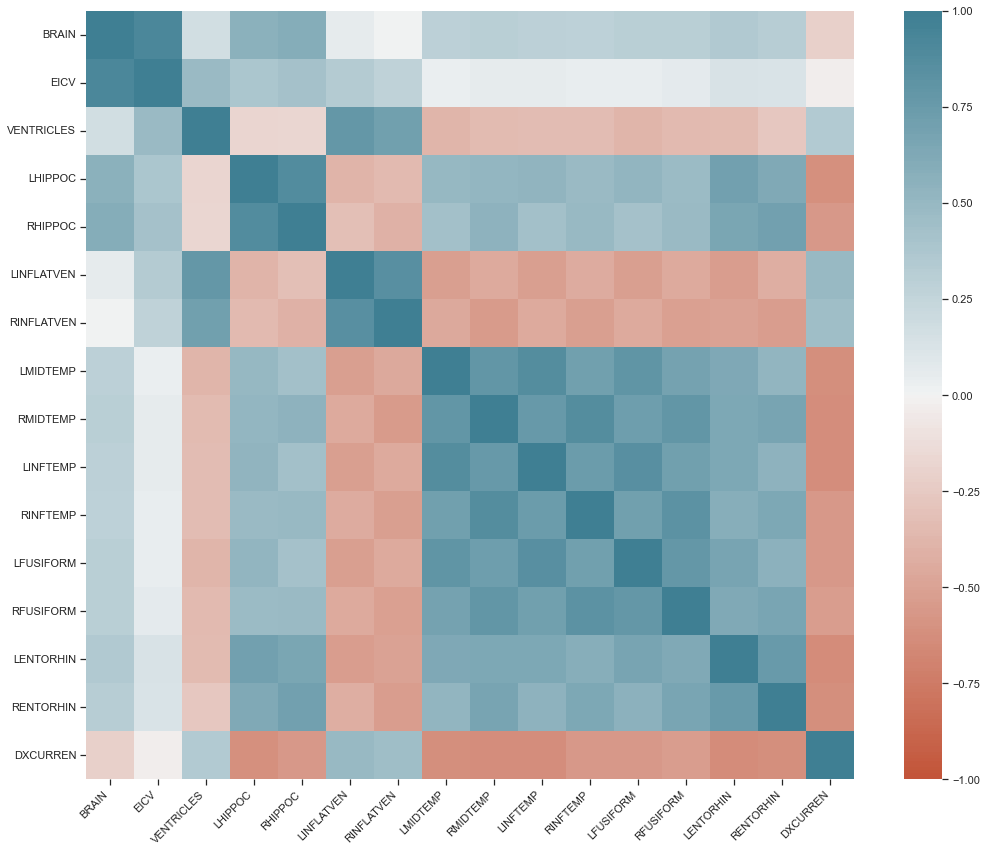

In [6]:
sns.set_style("ticks") # Adds tick marks to heatmap

correlation_matrix = df_raw.corr("spearman") # Matrix of correlation coefficients

# Note: Scaling is irrelevant in determining correlation

correlation_heatmap = df_raw.corr() # Allows us to find the correlation between DXCURREN and other features

fig, axis_heatmap = plt.subplots(figsize=(15,12))

axis_heatmap = sns.heatmap(
    correlation_heatmap, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
axis_heatmap.set_xticklabels(
    axis_heatmap.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.tight_layout()
#plt.savefig(r"./output/Figure_3.png")

In [7]:
correlation_matrix              # Correlation between all features
#correlation_matrix["DXCURREN"]  # Correlation between features and classification label

,BRAIN,EICV,VENTRICLES,LHIPPOC,RHIPPOC,LINFLATVEN,RINFLATVEN,LMIDTEMP,RMIDTEMP,LINFTEMP,RINFTEMP,LFUSIFORM,RFUSIFORM,LENTORHIN,RENTORHIN,DXCURREN
BRAIN,1.000000,0.912216,0.171445,0.549739,0.584769,0.050195,-0.020929,0.308598,0.308464,0.307999,0.287228,0.291732,0.296087,0.371555,0.364003,-0.226028
EICV,0.912216,1.000000,0.458553,0.374653,0.408710,0.327650,0.263568,0.054694,0.064329,0.066326,0.042950,0.032415,0.048521,0.141802,0.163297,-0.038578
VENTRICLES,0.171445,0.458553,1.000000,-0.247190,-0.238254,0.830020,0.796454,-0.422180,-0.367395,-0.395688,-0.374164,-0.432903,-0.424942,-0.393710,-0.299242,0.353714
LHIPPOC,0.549739,0.374653,-0.247190,1.000000,0.874785,-0.442392,-0.422129,0.528607,0.521768,0.542053,0.469562,0.507093,0.471870,0.717176,0.636071,-0.648595
RHIPPOC,0.584769,0.408710,-0.238254,0.874785,1.000000,-0.367566,-0.460156,0.460678,0.524862,0.460240,0.484583,0.417899,0.460472,0.645047,0.681786,-0.573802
LINFLATVEN,0.050195,0.327650,0.830020,-0.442392,-0.367566,1.000000,0.893438,-0.548805,-0.511528,-0.563565,-0.495576,-0.577902,-0.538813,-0.579499,-0.477725,0.545244
RINFLATVEN,-0.020929,0.263568,0.796454,-0.422129,-0.460156,0.893438,1.000000,-0.508791,-0.559244,-0.523404,-0.560481,-0.538415,-0.575997,-0.545290,-0.566856,0.500582
LMIDTEMP,0.308598,0.054694,-0.422180,0.528607,0.460678,-0.548805,-0.508791,1.000000,0.807146,0.860968,0.747335,0.802878,0.726210,0.643390,0.562646,-0.636356
RMIDTEMP,0.308464,0.064329,-0.367395,0.521768,0.524862,-0.511528,-0.559244,0.807146,1.000000,0.781866,0.851890,0.740773,0.760275,0.659568,0.650780,-0.646448
LINFTEMP,0.307999,0.066326,-0.395688,0.542053,0.460240,-0.563565,-0.523404,0.860968,0.781866,1.000000,0.759480,0.845207,0.736347,0.653315,0.588238,-0.662624


Looking at the above plot and table, BRAIN and EICV are very highly correlated. EICV has a very low correlation with DXCURREN (-0.039), so it seems likely to remove EICV as a feature.

Note that LHIPPOC and RHIPPOC, and LINFLATVEN and RINFLATVEN are fairly highly correlated.
By choosing the more correlated features, RHIPPOC could be removed in favour of LHIPPOC, and RINFLATVEN could be removed in favour of LINFLATVEN

### P-values

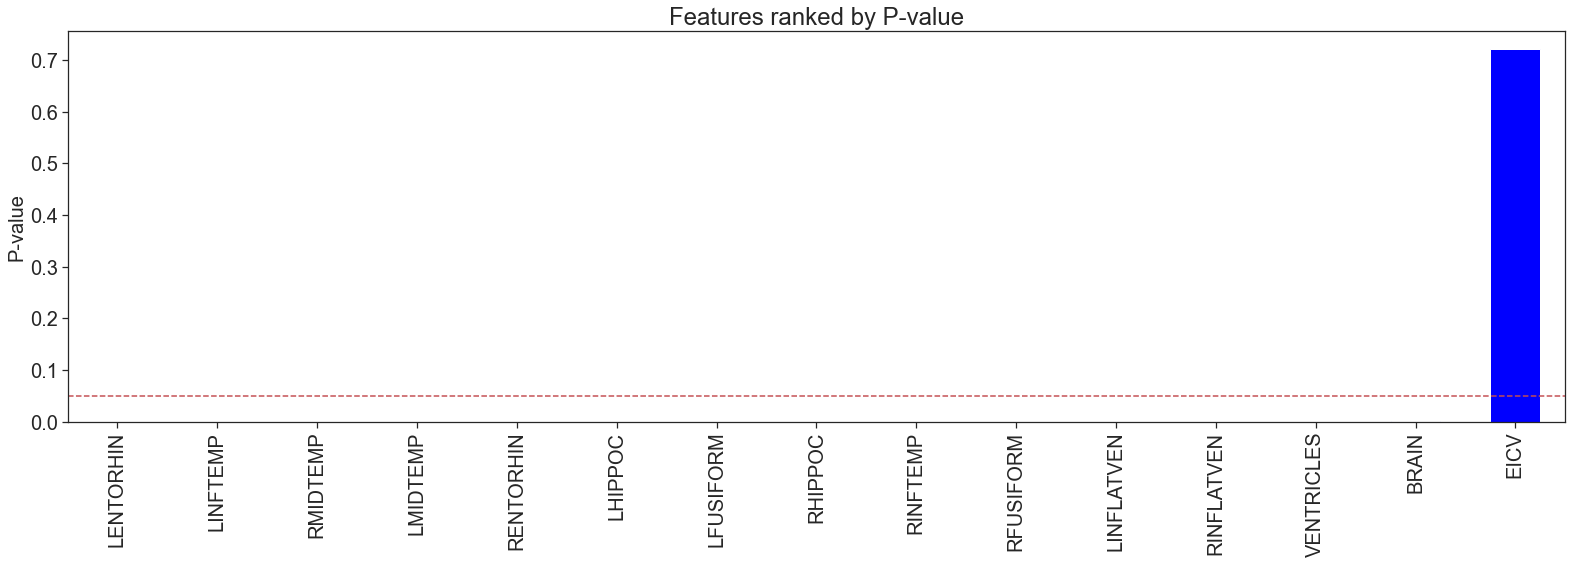

In [8]:
a=df_raw[df_raw["DXCURREN"]==0].drop(columns=["DXCURREN"])
b=df_raw[df_raw["DXCURREN"]==1].drop(columns=["DXCURREN"])

pvals_feature_ranking=(pd.DataFrame(stats.ttest_ind(a,b)).T).drop(columns=[0]).rename(columns={1: "p_value"})
pvals_feature_ranking.insert(0, "feature", df_raw.drop(columns=["DXCURREN"]).columns)

rank_pvals=(pd.DataFrame(stats.ttest_ind(a,b)).T).drop(columns=[0]).rename(columns={1: "p_value"})
rank_pvals.insert(0, "feature", df_raw.drop(columns=["DXCURREN"]).columns)
rank_pvals=rank_pvals.sort_values(by=['p_value'])

rank_pvals.plot.bar(x='feature', y='p_value', rot=0,figsize=(22,8), color='blue', legend = None)
plt.xticks(rotation='vertical',fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('')
plt.ylabel('P-value',fontsize=20)
plt.title('Features ranked by P-value',fontsize=24)
plt.axhline(y = 0.05, color = 'r', linestyle = '--'); # Adds a dotted line, which highlights significant variables
plt.tight_layout();
#plt.savefig(r"./output/Figure_1.png")

In [9]:
#pvals_feature_ranking

From the above graph and table, we want to remove features with a large p-value. Removing EICV is heavily suggested.

###### Note that the above p-values comes from t-tests of means between AD and CN patients for each feature. So, EICV is the only feature where means are not significantly different between types of patients

# Pre-processing data

In [10]:
# Using SMOTE is unnecessary

# But, scaling is necessary when working with algorithms that use distance, such as SVM

scale = StandardScaler()

scaled_data = scale.fit_transform(df_raw.drop(columns = "DXCURREN")) # Scale every column except the classifier

x_1 = pd.DataFrame(scaled_data, columns = [df_raw.columns[:-1]]) # x_1 = Dataframe of scaled data, with correct column names
y = df_raw["DXCURREN"]

# x_1 must be a pandas DataFrame
# y must be a pandas Series for the classifier to work

df = pd.concat([x_1,y], axis = 1)
df = pd.DataFrame(df, columns = [df_raw.columns[:-1]]) # Correctly re-names columns, but deletes DXCURREN 
df["DXCURREN"] = y # Re-adds DXCURREN column

In [11]:
#df_raw.head(3) # Unscaled data

In [12]:
#df.head(3) # Scaled data

# Implementing Machine Learning #1 - Before Feature Selection

### Training and testing data

In [13]:
x_train_1, x_test_1, y_train, y_test = train_test_split(x_1, y, test_size=0.3, random_state=10) 

# 70% training data, 30% testing data

# Note that x_1 is scaled here

### Random Forest Classifier

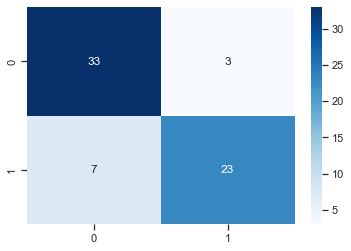

In [14]:
forest_classifier_1 = RandomForestClassifier(n_estimators = 500, random_state = 10)

forest_classifier_1.fit(x_train_1, y_train)

forest_predict_1 = forest_classifier_1.predict(x_test_1)

forest_matrix_1 = confusion_matrix(y_test, forest_predict_1)

sns.heatmap(forest_matrix_1, annot=True, fmt = "", cmap='Blues')

forest_sens_1 = sensitivity_score(y_test, forest_predict_1)
forest_spec_1 = specificity_score(y_test, forest_predict_1)
forest_acc_1 = accuracy_score(y_test, forest_predict_1)
forest_precision_1 = precision_score(y_test, forest_predict_1)
forest_f1_1 = f1_score(y_test, forest_predict_1)
forest_auc_1 = roc_auc_score(y_test, forest_predict_1)

### SVM Classifier

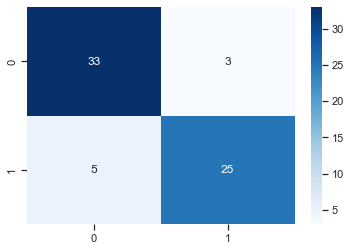

In [15]:
svc_1 = SVC(random_state = 10)

svc_1.fit(x_train_1, y_train)

svc_predict_1 = svc_1.predict(x_test_1)

svc_matrix_1 = confusion_matrix(y_test, svc_predict_1)

sns.heatmap(svc_matrix_1, annot=True, fmt = "", cmap='Blues')

svc_sens_1 = sensitivity_score(y_test, svc_predict_1) 
svc_spec_1 = specificity_score(y_test, svc_predict_1) 
svc_acc_1 = accuracy_score(y_test, svc_predict_1)
svc_precision_1 = precision_score(y_test, svc_predict_1)
svc_f1_1 = f1_score(y_test, svc_predict_1)
svc_auc_1 = roc_auc_score(y_test, svc_predict_1) 

### Comparing the two classifiers without feature selection

In [16]:
sensitivity_1 = pd.DataFrame([forest_sens_1, svc_sens_1], columns = ["Sensitivity"], index = ["Random Forest", "SVM"])
specificity_1 = pd.DataFrame([forest_spec_1, svc_spec_1], columns = ["Specificity"], index = ["Random Forest", "SVM"])
accuracy_1 = pd.DataFrame([forest_acc_1, svc_acc_1], columns = ["Accuracy"], index = ["Random Forest", "SVM"])
precision_1 = pd.DataFrame([forest_precision_1, svc_precision_1], columns = ["Precision"], index = ["Random Forest", "SVM"])
f1_1 = pd.DataFrame([forest_f1_1, svc_f1_1], columns = ["F1 Score"], index = ["Random Forest", "SVM"])
auc_1 = pd.DataFrame([forest_auc_1, svc_auc_1], columns = ["AUC"], index = ["Random Forest", "SVM"])


performance_without_selection = pd.DataFrame(index = ["Random Forest", "SVM"])

performance_without_selection["Sensitivity"] = sensitivity_1
performance_without_selection["Specificity"] = specificity_1
performance_without_selection["Accuracy"] = accuracy_1
performance_without_selection["Precision"] = precision_1
performance_without_selection["F1 Score"] = f1_1
performance_without_selection["AUC"] = auc_1

performance_without_selection
#performance_without_selection.to_csv(r"./output/perf_without_selection.txt", sep = ",", float_format = "{:.3f}".format)

,Sensitivity,Specificity,Accuracy,Precision,F1 Score,AUC
Random Forest,0.766667,0.916667,0.848485,0.884615,0.821429,0.841667
SVM,0.833333,0.916667,0.878788,0.892857,0.862069,0.875000


Without feature selection, SVM performs better than the Random Forest with 500 trees

### RFE: Feature selection

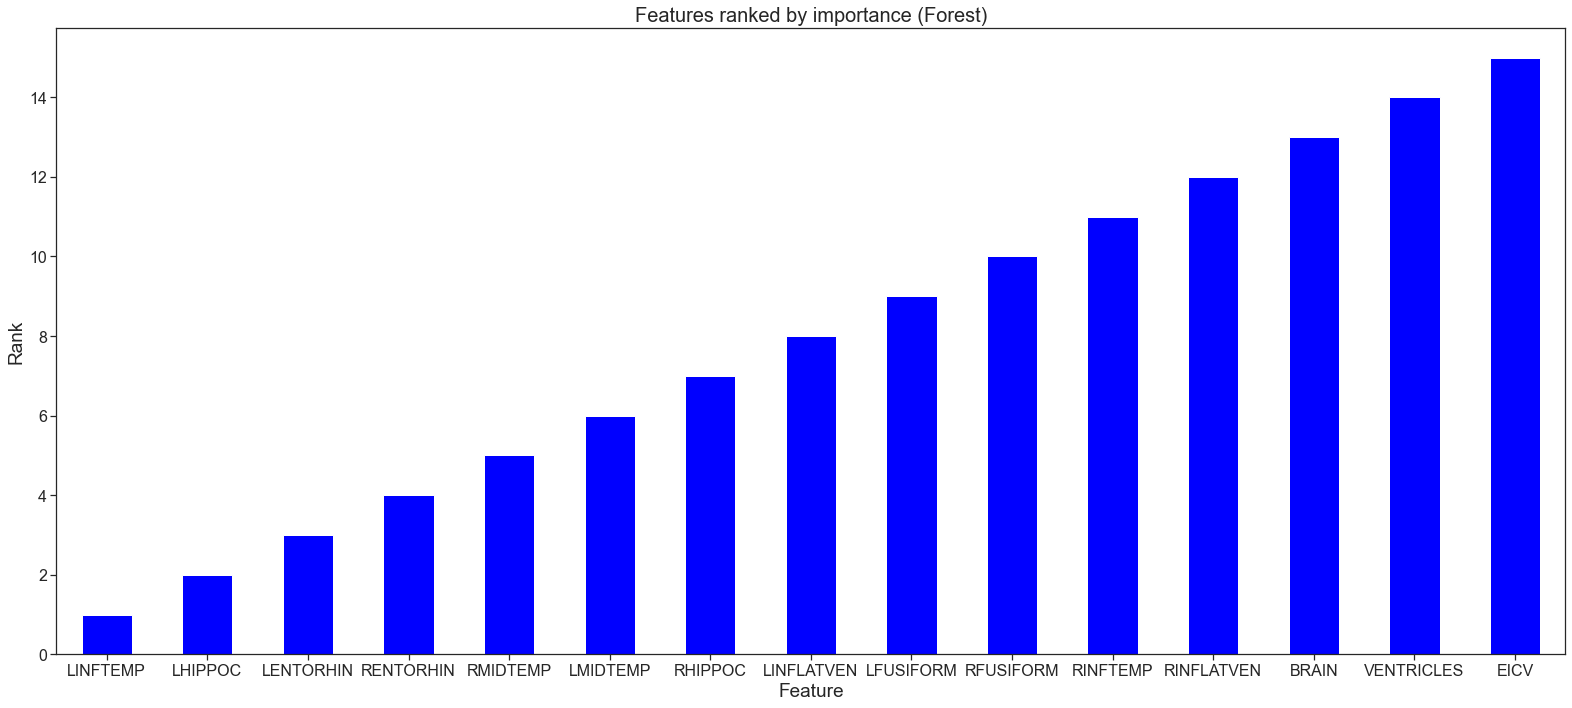

In [17]:
estimator_1 = RandomForestClassifier(n_estimators = 500, random_state = 10)

rfe_1 = RFE(estimator_1, n_features_to_select = 1).fit(x_1, y)
rf_ranking_1 = rfe_1.ranking_

features = df_raw.columns[0:-1] # x_1 has columns as a MultiIndex, df_raw uses a simple Index

ranked_ref_1=pd.DataFrame({'Feature': features, 'Rank':rf_ranking_1}).sort_values(by=['Rank'])

ranked_ref_1.plot.bar(x = "Feature", y = "Rank", rot = 0,figsize = (22,10), color = 'blue', legend = None)
plt.title('Features ranked by importance (Forest)',fontsize = 20)
plt.ylabel("Rank", fontsize = 19)
plt.yticks(fontsize = 16)
plt.xlabel("Feature", fontsize = 19)
plt.xticks(fontsize = 16)
plt.tight_layout();
#plt.savefig(r"./output/Figure_4.png")

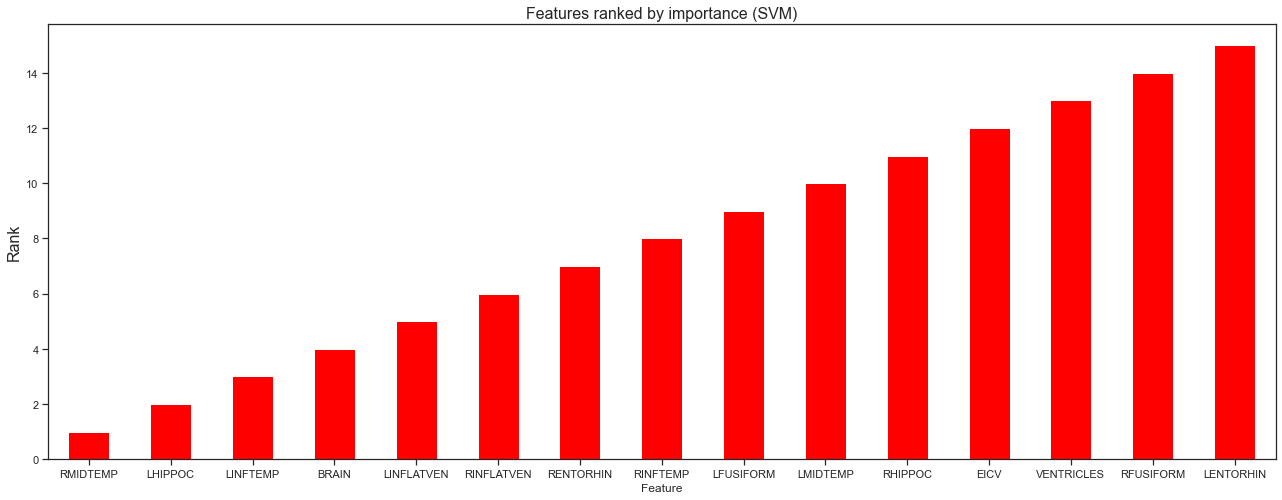

In [18]:
estimator_2 = SVC(random_state = 10,
                 kernel = "linear")

# Note that RFE only works with a linear kernel, as the linear kernel stores the feature importance
# By default, SVC uses an rbf kernel

# Note: SVM linear kernel performs better overall when comparing performance metrics

rfe_2 = RFE(estimator_2, n_features_to_select = 1)
rfe_2.fit(x_1, y)
rf_ranking_2 = rfe_2.ranking_

features = df_raw.columns[0:-1] # x_1 has columns as a MultiIndex, df_raw uses a simple Index

ranked_ref_2=pd.DataFrame({'Feature': features, 'Rank':rf_ranking_2}).sort_values(by=['Rank'])

ranked_ref_2.plot.bar(x = "Feature", y = "Rank", rot = 0,figsize = (22,8), color = 'red', legend = None)
plt.title('Features ranked by importance (SVM)',fontsize = 16)
plt.ylabel("Rank", fontsize = 16);

Only a linear kernel SVM could be used for Recursive Feature Elimination, whereas the best performing kernel was the rbf, which explains the large differences in ranked features

### SelectKBest feature selection

In [19]:
features_selectk=[] # Empty lists to be appended to

sensitivity_selectk_forest = []
specificity_selectk_forest = []
accuracy_selectk_forest=[]
precision_selectk_forest=[]
f1_selectk_forest=[]
auc_selectk_forest = []

sensitivity_selectk_svc = []
specificity_selectk_svc = []
accuracy_selectk_svc=[]
precision_selectk_svc=[]
f1_selectk_svc=[]
auc_selectk_svc = []


for i in range (1,x_1.columns.shape[0]+1):  # Ensures we iterate for every possible number of features

    feature_selection = SelectKBest(score_func=f_classif, k=i) # This is the object we iterate values for
    x_1_selected = feature_selection.fit_transform(x_1, y) # Applies feature selection
    
    cols_idxs = feature_selection.get_support(indices=True)
    selected_features = x_1.iloc[:,cols_idxs].columns # Every row from the columns of interest, and we only take the columns/ feature names
    
    # Create classifiers 
    clf_1 = RandomForestClassifier(n_estimators = 500, random_state=10)
    clf_2 = SVC(random_state = 10)

    clf_1.fit(x_train_1[selected_features], y_train) # We specifically only want rows of data with selected features
    clf_2.fit(x_train_1[selected_features], y_train)

    # Use the trained classifier to predict the labels of the test set
    clf_1_predict = clf_1.predict(x_test_1[selected_features])
    clf_2_predict = clf_2.predict(x_test_1[selected_features])
    
    forest_sens_selectk = sensitivity_score(y_test, clf_1_predict) # Random Forest performance metrics
    forest_spec_selectk = specificity_score(y_test, clf_1_predict)    
    forest_acc_selectk = accuracy_score(y_test, clf_1_predict)
    forest_precision_selectk = precision_score(y_test, clf_1_predict)
    forest_f1_selectk = f1_score(y_test, clf_1_predict)
    forest_auc_selectk = roc_auc_score(y_test, clf_1_predict)

    svc_sens_selectk = sensitivity_score(y_test, clf_2_predict) # SVM performance metrics
    svc_spec_selectk = specificity_score(y_test, clf_2_predict)
    svc_acc_selectk = accuracy_score(y_test, clf_2_predict)
    svc_precision_selectk = precision_score(y_test, clf_2_predict)
    svc_f1_selectk = f1_score(y_test, clf_2_predict)
    svc_auc_selectk = roc_auc_score(y_test, clf_2_predict)
    
    features_selectk.append(selected_features)
    sensitivity_selectk_forest.append(forest_sens_selectk)
    sensitivity_selectk_svc.append(svc_sens_selectk)
    specificity_selectk_forest.append(forest_spec_selectk)
    specificity_selectk_svc.append(svc_spec_selectk)
    accuracy_selectk_forest.append(forest_acc_selectk)
    accuracy_selectk_svc.append(svc_acc_selectk)
    precision_selectk_forest.append(forest_precision_selectk)
    precision_selectk_svc.append(svc_precision_selectk)
    f1_selectk_forest.append(forest_f1_selectk)
    f1_selectk_svc.append(svc_f1_selectk)
    auc_selectk_forest.append(forest_auc_selectk)
    auc_selectk_svc.append(svc_auc_selectk)
    
    
selected_features_per=pd.DataFrame()
selected_features_per["Number of features"] = list(range(1,len(features_selectk)+1))
selected_features_per["Sensitivity (Forest)"] = sensitivity_selectk_forest
selected_features_per["Sensitivity (SVM)"] = sensitivity_selectk_svc
selected_features_per["Specificity (Forest)"] = specificity_selectk_forest
selected_features_per["Specificity (SVM)"] = specificity_selectk_svc
selected_features_per["Accuracy (Forest)"] = accuracy_selectk_forest
selected_features_per["Accuracy (SVM)"] = accuracy_selectk_svc
selected_features_per["Precision (Forest)"] = precision_selectk_forest
selected_features_per["Precision (SVM)"] = precision_selectk_svc
selected_features_per["F1 Score (Forest)"] = f1_selectk_forest
selected_features_per["F1 Score (SVM)"] = f1_selectk_svc
selected_features_per["AUC (Forest)"] = auc_selectk_forest
selected_features_per["AUC (SVM)"] = auc_selectk_svc


selected_features_per
#selected_features_per.to_csv(r"./output/selectkbest.txt", sep = ",", float_format = "{:.3f}".format)

,Number of features,Sensitivity (Forest),Sensitivity (SVM),Specificity (Forest),Specificity (SVM),Accuracy (Forest),Accuracy (SVM),Precision (Forest),Precision (SVM),F1 Score (Forest),F1 Score (SVM),AUC (Forest),AUC (SVM)
0,1,0.700000,0.800000,0.777778,0.888889,0.742424,0.848485,0.724138,0.857143,0.711864,0.827586,0.738889,0.844444
1,2,0.766667,0.733333,0.888889,0.916667,0.833333,0.833333,0.851852,0.880000,0.807018,0.800000,0.827778,0.825000
2,3,0.766667,0.700000,0.916667,0.888889,0.848485,0.803030,0.884615,0.840000,0.821429,0.763636,0.841667,0.794444
3,4,0.766667,0.766667,0.833333,0.861111,0.803030,0.818182,0.793103,0.821429,0.779661,0.793103,0.800000,0.813889
4,5,0.766667,0.766667,0.888889,0.916667,0.833333,0.848485,0.851852,0.884615,0.807018,0.821429,0.827778,0.841667
5,6,0.833333,0.833333,0.888889,0.972222,0.863636,0.909091,0.862069,0.961538,0.847458,0.892857,0.861111,0.902778
6,7,0.800000,0.833333,0.861111,0.972222,0.833333,0.909091,0.827586,0.961538,0.813559,0.892857,0.830556,0.902778
7,8,0.800000,0.833333,0.888889,0.972222,0.848485,0.909091,0.857143,0.961538,0.827586,0.892857,0.844444,0.902778
8,9,0.800000,0.833333,0.888889,0.916667,0.848485,0.878788,0.857143,0.892857,0.827586,0.862069,0.844444,0.875000
9,10,0.800000,0.833333,0.888889,0.916667,0.848485,0.878788,0.857143,0.892857,0.827586,0.862069,0.844444,0.875000


In [20]:
features_selectk # The recommended features when restricting the number of features

[MultiIndex([('LENTORHIN',)],
            ),
 MultiIndex([( 'LINFTEMP',),
             ('LENTORHIN',)],
            ),
 MultiIndex([( 'RMIDTEMP',),
             ( 'LINFTEMP',),
             ('LENTORHIN',)],
            ),
 MultiIndex([( 'LMIDTEMP',),
             ( 'RMIDTEMP',),
             ( 'LINFTEMP',),
             ('LENTORHIN',)],
            ),
 MultiIndex([( 'LMIDTEMP',),
             ( 'RMIDTEMP',),
             ( 'LINFTEMP',),
             ('LENTORHIN',),
             ('RENTORHIN',)],
            ),
 MultiIndex([(  'LHIPPOC',),
             ( 'LMIDTEMP',),
             ( 'RMIDTEMP',),
             ( 'LINFTEMP',),
             ('LENTORHIN',),
             ('RENTORHIN',)],
            ),
 MultiIndex([(  'LHIPPOC',),
             ( 'LMIDTEMP',),
             ( 'RMIDTEMP',),
             ( 'LINFTEMP',),
             ('LFUSIFORM',),
             ('LENTORHIN',),
             ('RENTORHIN',)],
            ),
 MultiIndex([(  'LHIPPOC',),
             (  'RHIPPOC',),
             ( 'LM

SelectKbest suggests the optimal model uses 6 features from our dataset, and SVM always outperforms Random Forests with 500 trees.

The 6 optimal features are: LHIPPOC, LMIDTEMP, RMIDTEMP, LINFTEMP, LENTORHIN, RENTORHIN

### Non-publication plot:

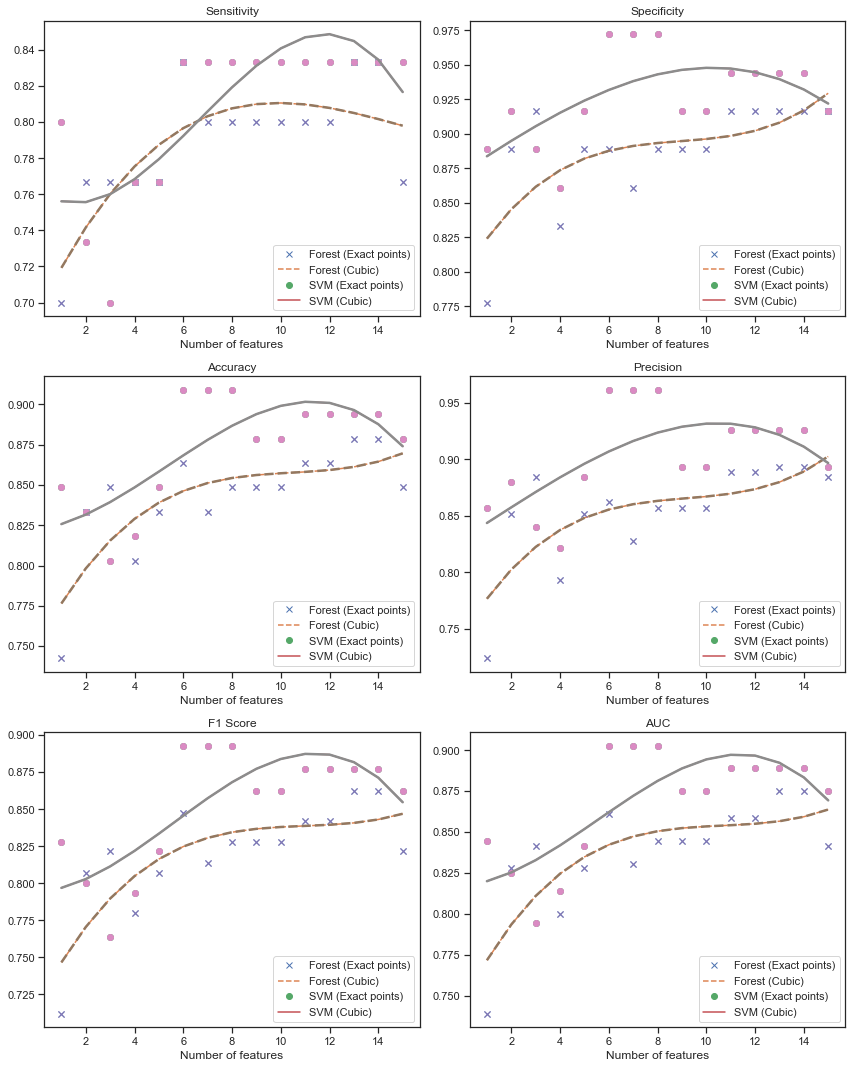

In [21]:
fig_select, axis_select = plt.subplots(3,2, figsize = (12, 15)) # 3 rows and 2 columns of plots

x=selected_features_per["Number of features"]

count = 1

for i in range(0,3):      # i is the row
    for j in range(0, 2): # j is the column
        y_forest = selected_features_per.iloc[:, count]
        y_svc = selected_features_per.iloc[:, (count + 1)]
        performance_metric = (y_forest.name.split()[0].title()) # Our performance metric of interest
        if performance_metric == "Auc":
            performance_metric = "AUC" # Ensures "AUC" is properly capitalised as a title
        elif performance_metric == "F1":
            performance_metric = "F1 Score"
        
        p_forest = np.poly1d(np.polyfit(x, y_forest, 3)) # Polynomials representing points
        p_svc = np.poly1d(np.polyfit(x, y_svc, 3))
        
        forest_point = axis_select[i,j].plot(x, y_forest, "x", label = "Forest (Exact points)")
        forest_line = axis_select[i,j].plot(x, p_forest(x), "--", label = "Forest (Cubic)")
        svc_point = axis_select[i,j].plot(x, y_svc, "o", label = "SVM (Exact points)")
        svc_line = axis_select[i,j].plot(x, p_svc(x), "-", label = "SVM (Cubic)")
        
        axis_select[i,j].plot(x, y_forest, "x", x, p_forest(x), "--", x, y_svc, "o", x, p_svc(x), "-", lw = 2.5)
        axis_select[i,j].set_title(performance_metric) # Automatically generates title based off column name
        axis_select[i,j].legend()
        count += 2 # Ensures we internally move between different performance metrics
        
for axis_select in axis_select.flat:
    axis_select.set(xlabel="Number of features") # Sets x-axis label constant for all plots
    
plt.tight_layout()
#plt.savefig(r"./output/Figure_5.png")

### Publication plot:

In [22]:
matplotlib.rc("xtick", labelsize = 25) # This changes global parameters, but as it is the final plot in the report it is okay
matplotlib.rc("ytick", labelsize = 25)
matplotlib.rc("axes", labelsize = 25)

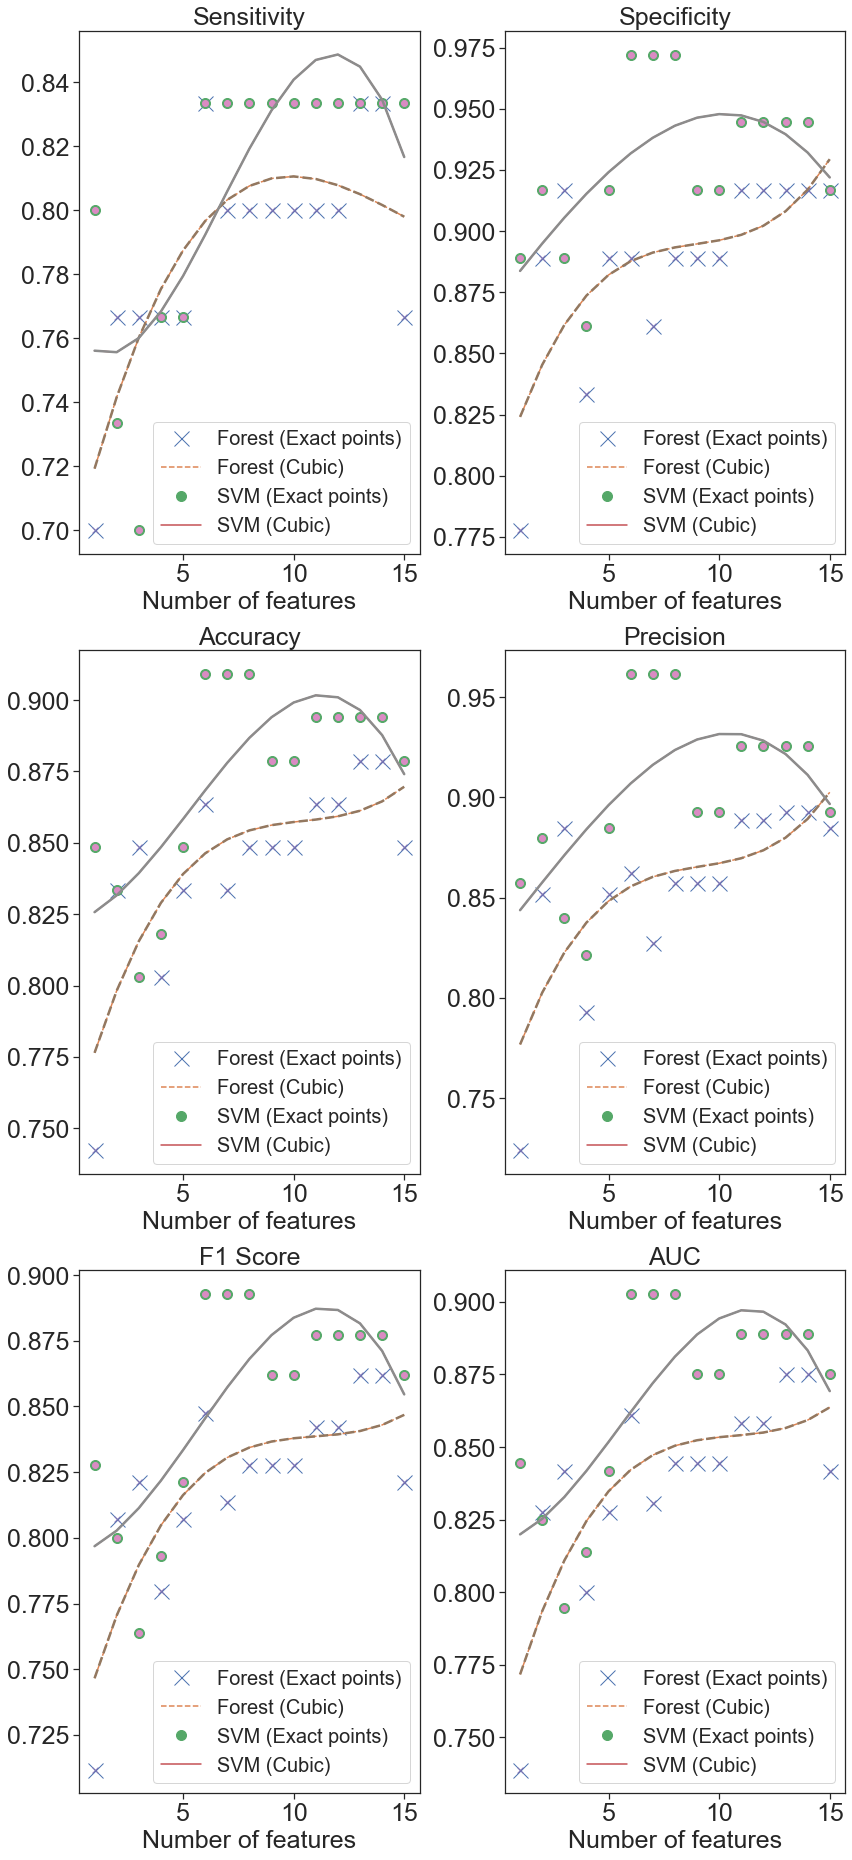

In [23]:
fig_select, axis_select = plt.subplots(3,2, figsize = (12, 26)) # 3 rows and 2 columns of plots

x=selected_features_per["Number of features"]

count = 1

for i in range(0,3):      # i is the row
    for j in range(0, 2): # j is the column
        y_forest = selected_features_per.iloc[:, count]
        y_svc = selected_features_per.iloc[:, (count + 1)]
        performance_metric = (y_forest.name.split()[0].title()) # Our performance metric of interest
        if performance_metric == "Auc":
            performance_metric = "AUC" # Ensures "AUC" is properly capitalised as a title
        elif performance_metric == "F1":
            performance_metric = "F1 Score"
        
        p_forest = np.poly1d(np.polyfit(x, y_forest, 3)) # Polynomials representing points
        p_svc = np.poly1d(np.polyfit(x, y_svc, 3))
        
        forest_point = axis_select[i,j].plot(x, y_forest, "x", label = "Forest (Exact points)", markersize = 15)
        forest_line = axis_select[i,j].plot(x, p_forest(x), "--", label = "Forest (Cubic)")
        svc_point = axis_select[i,j].plot(x, y_svc, "o", label = "SVM (Exact points)", markersize = 10)
        svc_line = axis_select[i,j].plot(x, p_svc(x), "-", label = "SVM (Cubic)")
        
        axis_select[i,j].plot(x, y_forest, "x", x, p_forest(x), "--", x, y_svc, "o", x, p_svc(x), "-", lw = 2.5)
        axis_select[i,j].set_title(performance_metric, fontsize = 25) # Automatically generates title based off column name
        axis_select[i,j].legend(fontsize = 20)
        count += 2 # Ensures we internally move between different performance metrics
        
for axis_select in axis_select.flat:
    axis_select.set(xlabel="Number of features") # Sets x-axis label constant for all plots
    
plt.tight_layout()
#plt.savefig(r"./output/Figure_5.png")

The absolute best performance when looking at exact points occurs when 6 features are used for SVM. Random Forest seems to flatten down after 6 features using the cubics, further suggesting 6 feautres is optimal.

However, 11 features is the peak of the SVM cubics. As the cubic theoretically represents the rougher underlying relationship rather than specific points, 11 features may be chosen.

A 6 feature model may be more accurate here, but it's possible this would result in an overfitting model for our specific data due to the points peaking and not the cubic representation. Thus, an 11 feature model may be more appropriate in a general setting

The 11 feature SVM model using SelectKBest will have the features: LHIPPOC, RHIPPOC, LINFLATVEN, LMIDTEMP, RMIDTEMP, LINFTEMP, RINFTEMP, LFUSIFORM, RFUSIFORM, LENTORHIN, RENTORHIN.

In comparison, the 6 feature SVM model will have: LHIPPOC, LMIDTEMP, RMIDTEMP, LINFTEMP, LENTORHIN, RENTORHIN.

Choosing LINFLATVEN over RINFLATVEN agrees with the correlation findings earlier. Also, analysing volumes of the hippocampus and medial temporal lobes (LMIDTEMP and RMIDTEMP) agree with the previous studies.

The 4 features removed are BRAIN, EICV, VENTRICLES, RINFLATVEN

###### Note that other kernels were tested, but the default rbf (radial basis function) performed best

# Implementing Machine Learning #2 - 11 Features, decided with SelectKBest

In [24]:
x_2 = x_1.drop(columns = ["BRAIN", "EICV", "VENTRICLES", "RINFLATVEN"])

x_train_2, x_test_2, y_train, y_test = train_test_split(x_2, y, test_size=0.3, random_state=10) 

matplotlib.style.use("default") # Restores default matplotlib.rc() settings

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


### Random Forest Classifier

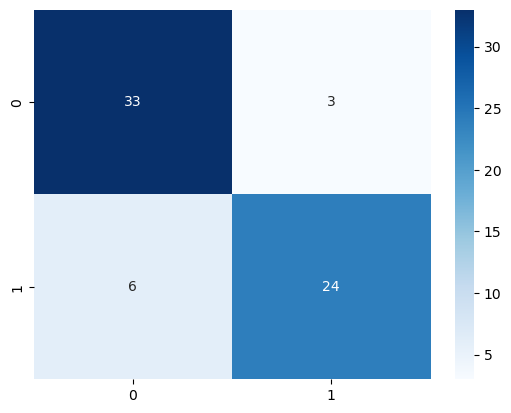

In [25]:
forest_classifier_2 = RandomForestClassifier(n_estimators = 500, random_state = 10)

forest_classifier_2.fit(x_train_2, y_train)

forest_predict_2 = forest_classifier_2.predict(x_test_2)

forest_matrix_2 = confusion_matrix(y_test, forest_predict_2)

sns.heatmap(forest_matrix_2, annot=True, fmt = "", cmap='Blues')

forest_sens_2 = sensitivity_score(y_test, forest_predict_2)
forest_spec_2 = specificity_score(y_test, forest_predict_2)
forest_acc_2 = accuracy_score(y_test, forest_predict_2)
forest_precision_2 = precision_score(y_test, forest_predict_2)
forest_f1_2 = f1_score(y_test, forest_predict_2)
forest_auc_2 = roc_auc_score(y_test, forest_predict_2)

### SVM

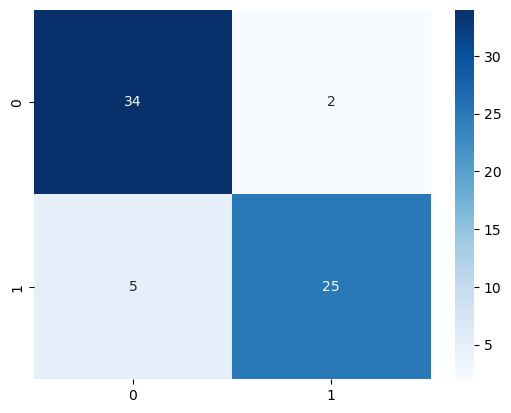

In [26]:
svc_2 = SVC(random_state = 10)

svc_2.fit(x_train_2, y_train)

svc_predict_2 = svc_2.predict(x_test_2)

svc_matrix_2 = confusion_matrix(y_test, svc_predict_2)

sns.heatmap(svc_matrix_2, annot=True, fmt = "", cmap='Blues')

svc_sens_2 = sensitivity_score(y_test, svc_predict_2)
svc_spec_2 = specificity_score(y_test, svc_predict_2)
svc_acc_2 = accuracy_score(y_test, svc_predict_2)
svc_precision_2 = precision_score(y_test, svc_predict_2)
svc_f1_2 = f1_score(y_test, svc_predict_2)
svc_auc_2 = roc_auc_score(y_test, svc_predict_2)

### Comparing the two classifiers

In [27]:
sensitivity_2 = pd.DataFrame([forest_sens_2, svc_sens_2], columns = ["Sensitivity"], index = ["Random Forest", "SVM"])
specificity_2 = pd.DataFrame([forest_spec_2, svc_spec_2], columns = ["Specificity"], index = ["Random Forest", "SVM"])
accuracy_2 = pd.DataFrame([forest_acc_2, svc_acc_2], columns = ["Accuracy"], index = ["Random Forest", "SVM"])
precision_2 = pd.DataFrame([forest_precision_2, svc_precision_2], columns = ["Precision"], index = ["Random Forest", "SVM"])
f1_2 = pd.DataFrame([forest_f1_2, svc_f1_2], columns = ["F1 Score"], index = ["Random Forest", "SVM"])
auc_2 = pd.DataFrame([forest_auc_2, svc_auc_2], columns = ["AUC"], index = ["Random Forest", "SVM"])

performance_with_selection_1 = pd.DataFrame(index = ["Random Forest", "SVM"])

performance_with_selection_1["Sensitivity"] = sensitivity_2
performance_with_selection_1["Specificity"] = specificity_2
performance_with_selection_1["Accuracy"] = accuracy_2
performance_with_selection_1["Precision"] = precision_2
performance_with_selection_1["F1 Score"] = f1_2
performance_with_selection_1["AUC"] = auc_2

performance_with_selection_1

,Sensitivity,Specificity,Accuracy,Precision,F1 Score,AUC
Random Forest,0.800000,0.916667,0.863636,0.888889,0.842105,0.858333
SVM,0.833333,0.944444,0.893939,0.925926,0.877193,0.888889


# Implementing Machine Learning #3 - 12 Features, decided by removing highly correlated features

In [28]:
x_3 = x_1.drop(columns = ["EICV", "RHIPPOC", "RINFLATVEN"])

# Deleting features that are highly correlated

x_train_3, x_test_3, y_train, y_test = train_test_split(x_3, y, test_size=0.3, random_state=10) 

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


### Random Forest

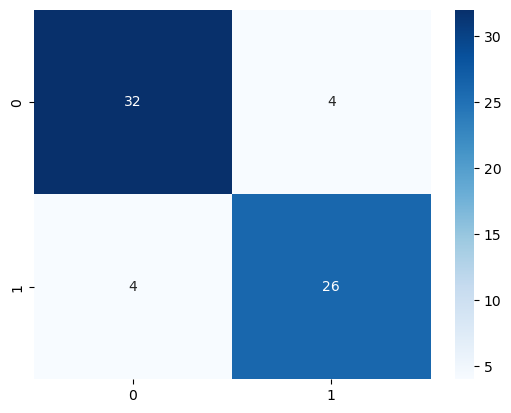

In [29]:
forest_classifier_3 = RandomForestClassifier(n_estimators = 500, random_state = 10)

forest_classifier_3.fit(x_train_3, y_train)

forest_predict_3 = forest_classifier_3.predict(x_test_3)

forest_matrix_3 = confusion_matrix(y_test, forest_predict_3)

sns.heatmap(forest_matrix_3, annot=True, fmt = "", cmap='Blues')

forest_sens_3 = sensitivity_score(y_test, forest_predict_3)
forest_spec_3 = specificity_score(y_test, forest_predict_3)
forest_acc_3 = accuracy_score(y_test, forest_predict_3)
forest_precision_3 = precision_score(y_test, forest_predict_3)
forest_f1_3 = f1_score(y_test, forest_predict_3)
forest_auc_3 = roc_auc_score(y_test, forest_predict_3)

### SVM

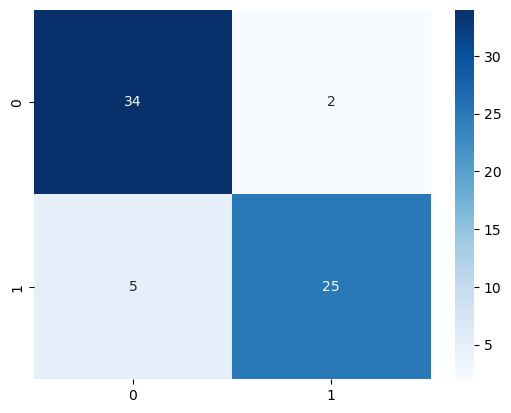

In [30]:
svc_3 = SVC(random_state = 10)

svc_3.fit(x_train_3, y_train)

svc_predict_3 = svc_3.predict(x_test_3)

svc_matrix_3 = confusion_matrix(y_test, svc_predict_3)

sns.heatmap(svc_matrix_3, annot=True, fmt = "", cmap='Blues')

svc_sens_3 = sensitivity_score(y_test, svc_predict_3)
svc_spec_3 = specificity_score(y_test, svc_predict_3)
svc_acc_3 = accuracy_score(y_test, svc_predict_3)
svc_precision_3 = precision_score(y_test, svc_predict_3)
svc_f1_3 = f1_score(y_test, svc_predict_3)
svc_auc_3 = roc_auc_score(y_test, svc_predict_3)

### Comparing the two classifiers

In [31]:
sensitivity_3 = pd.DataFrame([forest_sens_3, svc_sens_3], columns = ["Sensitivity"], index = ["Random Forest", "SVM"])
specificity_3 = pd.DataFrame([forest_spec_3, svc_spec_3], columns = ["Specificity"], index = ["Random Forest", "SVM"])
accuracy_3 = pd.DataFrame([forest_acc_3, svc_acc_3], columns = ["Accuracy"], index = ["Random Forest", "SVM"])
precision_3 = pd.DataFrame([forest_precision_3, svc_precision_3], columns = ["Precision"], index = ["Random Forest", "SVM"])
f1_3 = pd.DataFrame([forest_f1_3, svc_f1_3], columns = ["F1 Score"], index = ["Random Forest", "SVM"])
auc_3 = pd.DataFrame([forest_auc_3, svc_auc_3], columns = ["AUC"], index = ["Random Forest", "SVM"])


performance_with_selection_2 = pd.DataFrame(index = ["Random Forest", "SVM"])

performance_with_selection_2["Sensitivity"] = sensitivity_3
performance_with_selection_2["Specificity"] = specificity_3
performance_with_selection_2["Accuracy"] = accuracy_3
performance_with_selection_2["Precision"] = precision_3
performance_with_selection_2["F1 Score"] = f1_3
performance_with_selection_2["AUC"] = auc_3

performance_with_selection_2

,Sensitivity,Specificity,Accuracy,Precision,F1 Score,AUC
Random Forest,0.866667,0.888889,0.878788,0.866667,0.866667,0.877778
SVM,0.833333,0.944444,0.893939,0.925926,0.877193,0.888889


# Implementing Machine Learning #4 - 10 Features, decided by removing highly correlated features, and features classed as unimportant using SelectKBest

In [32]:
x_4 = x_1.drop(columns = ["BRAIN", "VENTRICLES", "EICV", "RHIPPOC", "RINFLATVEN"])

# Deleting highly correlated features, and features deemed unimportant using SelectKBest

x_train_4, x_test_4, y_train, y_test = train_test_split(x_4, y, test_size=0.3, random_state=10) 

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


### Random Forest

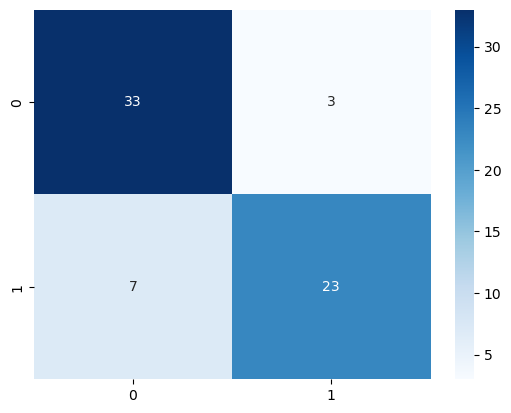

In [33]:
forest_classifier_4 = RandomForestClassifier(n_estimators = 500, random_state = 10)

forest_classifier_4.fit(x_train_4, y_train)

forest_predict_4 = forest_classifier_4.predict(x_test_4)

forest_matrix_4 = confusion_matrix(y_test, forest_predict_4)

sns.heatmap(forest_matrix_4, annot=True, fmt = "", cmap='Blues')

forest_sens_4 = sensitivity_score(y_test, forest_predict_4)
forest_spec_4 = specificity_score(y_test, forest_predict_4)
forest_acc_4 = accuracy_score(y_test, forest_predict_4)
forest_precision_4 = precision_score(y_test, forest_predict_4)
forest_f1_4 = f1_score(y_test, forest_predict_4)
forest_auc_4 = roc_auc_score(y_test, forest_predict_4)

### SVM

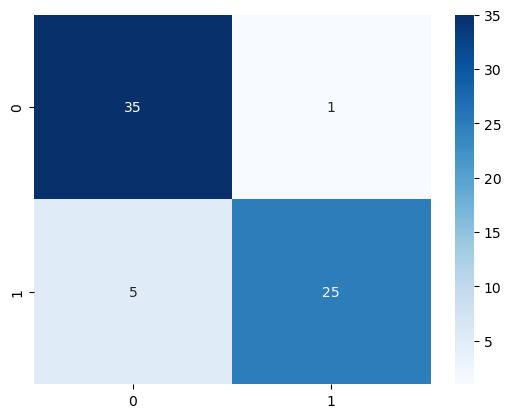

In [34]:
svc_4 = SVC(random_state = 10)

svc_4.fit(x_train_4, y_train)

svc_predict_4 = svc_4.predict(x_test_4)

svc_matrix_4 = confusion_matrix(y_test, svc_predict_4)

sns.heatmap(svc_matrix_4, annot=True, fmt = "", cmap='Blues')

svc_sens_4 = sensitivity_score(y_test, svc_predict_4)
svc_spec_4 = specificity_score(y_test, svc_predict_4)
svc_acc_4 = accuracy_score(y_test, svc_predict_4)
svc_precision_4 = precision_score(y_test, svc_predict_4)
svc_f1_4 = f1_score(y_test, svc_predict_4)
svc_auc_4 = roc_auc_score(y_test, svc_predict_4)

### Comparing the two classifiers without feature selection

In [35]:
sensitivity_4 = pd.DataFrame([forest_sens_4, svc_sens_4], columns = ["Sensitivity"], index = ["Random Forest", "SVM"])
specificity_4 = pd.DataFrame([forest_spec_4, svc_spec_4], columns = ["Specificity"], index = ["Random Forest", "SVM"])
accuracy_4 = pd.DataFrame([forest_acc_4, svc_acc_4], columns = ["Accuracy"], index = ["Random Forest", "SVM"])
precision_4 = pd.DataFrame([forest_precision_4, svc_precision_4], columns = ["Precision"], index = ["Random Forest", "SVM"])
f1_4 = pd.DataFrame([forest_f1_4, svc_f1_4], columns = ["F1 Score"], index = ["Random Forest", "SVM"])
auc_4 = pd.DataFrame([forest_auc_4, svc_auc_4], columns = ["AUC"], index = ["Random Forest", "SVM"])

performance_with_selection_3 = pd.DataFrame(index = ["Random Forest", "SVM"])

performance_with_selection_3["Sensitivity"] = sensitivity_4
performance_with_selection_3["Specificity"] = specificity_4
performance_with_selection_3["Accuracy"] = accuracy_4
performance_with_selection_3["Precision"] = precision_4
performance_with_selection_3["F1 Score"] = f1_4
performance_with_selection_3["AUC"] = auc_4

performance_with_selection_3

,Sensitivity,Specificity,Accuracy,Precision,F1 Score,AUC
Random Forest,0.766667,0.916667,0.848485,0.884615,0.821429,0.841667
SVM,0.833333,0.972222,0.909091,0.961538,0.892857,0.902778


# Comparing Models

In [36]:
performance_without_selection # All 15 features

,Sensitivity,Specificity,Accuracy,Precision,F1 Score,AUC
Random Forest,0.766667,0.916667,0.848485,0.884615,0.821429,0.841667
SVM,0.833333,0.916667,0.878788,0.892857,0.862069,0.875000


In [37]:
performance_with_selection_1 # 11 features: Removed BRAIN, EICV, VENTRICLES and RINFLATVEN
#performance_with_selection_1.to_csv(r"./output/Table_4_1.txt", sep = ",", float_format = "{:.3f}".format)

,Sensitivity,Specificity,Accuracy,Precision,F1 Score,AUC
Random Forest,0.800000,0.916667,0.863636,0.888889,0.842105,0.858333
SVM,0.833333,0.944444,0.893939,0.925926,0.877193,0.888889


In [38]:
performance_with_selection_2 # 12 features: Removed EICV, RHIPPOC and RINFLATVEN
#performance_with_selection_2.to_csv(r"./output/Table_4_2.txt", sep = ",", float_format = "{:.3f}".format)

,Sensitivity,Specificity,Accuracy,Precision,F1 Score,AUC
Random Forest,0.866667,0.888889,0.878788,0.866667,0.866667,0.877778
SVM,0.833333,0.944444,0.893939,0.925926,0.877193,0.888889


In [39]:
performance_with_selection_3 # 10 features: Removed BRAIN, VENTRICLES, EICV, RHIPPOC, and RINFLATVEN
#performance_with_selection_3.to_csv(r"./output/Table_4_3.txt", sep = ",", float_format = "{:.3f}".format)

,Sensitivity,Specificity,Accuracy,Precision,F1 Score,AUC
Random Forest,0.766667,0.916667,0.848485,0.884615,0.821429,0.841667
SVM,0.833333,0.972222,0.909091,0.961538,0.892857,0.902778


The final model performs best on our data. Technically, the accuracy is the same as that of the 6 feature model chosen using SelectKBest, but using the idea of the trend demonstrated earlier, this 10 feature SVM model should be more appropriate in a general setting

##### Note we can keep BRAIN, and performance metrics do not change at all from our final model, so we'll remove it

##### Also note: The last three of the above tables were imported to Word, and column titles were deleted for presentation purposes